In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import warnings

In [56]:
start_date='2010-04-01'
end_date='2023-4-23'
ticker='NVDA'
def rolling_strategy(s,e,tic,ma1,ma2):
    # suppress all warnings
    warnings.filterwarnings("ignore")
    df=yf.download(tic,start=start_date,end=end_date)
    price=df[['Adj Close']]
    price = price.rename(columns={'Adj Close': tic})

    MA1='MA{}'.format(str(ma1))
    MA2='MA{}'.format(str(ma2))
    price[MA1]=price[tic].rolling(window=ma1).mean()
    price[MA2]=price[tic].rolling(window=ma2).mean()
    price=price.dropna()
    price[[tic,MA1,MA2]].plot()
    price['Position']=np.where(price[MA1]>price[MA2],1,0)
    detect=price['Position'].diff()
    flip_indices=price.index[detect!=0].to_list()
    print('Position changes at ',flip_indices)
    ax = price.plot(secondary_y='Position', figsize=(10, 6))
    ax.get_legend().set_bbox_to_anchor((0.25, 0.85))
    price['Return']=price[tic].pct_change().fillna(0)
    price=price.rename(columns={'Return':'Long Only'})
    price['Strategy']=price['Long Only'].shift(1)*price['Position']
    price.dropna(inplace=True)
    mean_ret=price[['Long Only','Strategy']].mean()*252
    ret=(1+price[['Long Only','Strategy']]).cumprod()
    ret.plot()
    std=price[['Long Only','Strategy']].std()*252**0.5
    sharpe=mean_ret/std
    
    # reset the warnings filter
    warnings.filterwarnings("default")
    print('Total return for ',tic)
    print(ret.iloc[-1,:])
    print('Annualized Vol for ',tic)
    print(std)
    print('Annualized Sharpe for ',tic)
    print(sharpe)

[*********************100%***********************]  1 of 1 completed
Position changes at  [Timestamp('2011-01-13 00:00:00'), Timestamp('2011-07-08 00:00:00'), Timestamp('2012-02-23 00:00:00'), Timestamp('2012-04-27 00:00:00'), Timestamp('2012-09-14 00:00:00'), Timestamp('2012-10-04 00:00:00'), Timestamp('2013-04-30 00:00:00'), Timestamp('2015-07-27 00:00:00'), Timestamp('2015-08-31 00:00:00'), Timestamp('2018-11-06 00:00:00'), Timestamp('2019-08-12 00:00:00'), Timestamp('2022-04-18 00:00:00'), Timestamp('2023-01-24 00:00:00')]
Total return for  NVDA
Long Only    50.541908
Strategy     67.523215
Name: 2023-04-21 00:00:00, dtype: float64
Annualized Vol for  NVDA
Long Only    0.445041
Strategy     0.364037
dtype: float64
Annualized Sharpe for  NVDA
Long Only    0.940924
Strategy     1.124566
dtype: float64


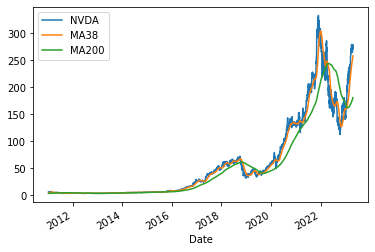

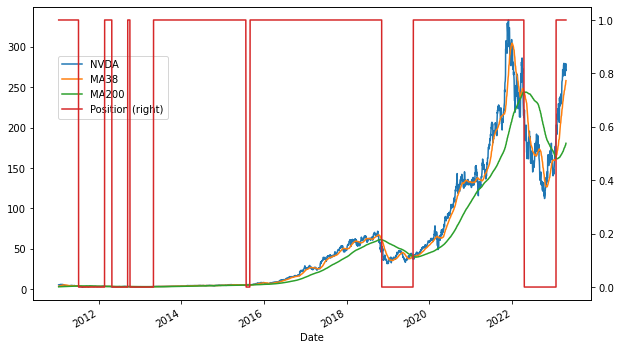

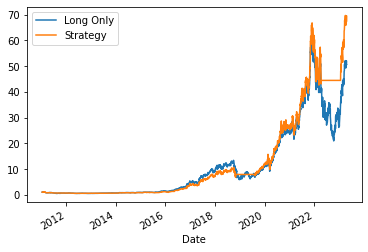

In [57]:
rolling_strategy(start_date,end_date,'NVDA',38,200)

In [119]:
def build_pnl(df,ma1,ma2):
    # suppress all warnings
    warnings.filterwarnings("ignore")
    price=df[['Adj Close']]
    MA1='MA{}'.format(str(ma1))
    MA2='MA{}'.format(str(ma2))
    price[MA1]=price['Adj Close'].rolling(window=int(ma1)).mean()
    price[MA2]=price['Adj Close'].rolling(window=int(ma2)).mean()
    price=price.dropna()
    price['Position']=np.where(price[MA1]>price[MA2],1,-1)
    price['Return']=price['Adj Close'].pct_change().fillna(0)
    price['Return']=price['Return'].shift(1)*price['Position']
    price['pnl']=(1+price['Return']).cumprod()
    price.dropna(inplace=True)
    return price[['Return']],price['pnl'][-1]

In [35]:
def rolling_strategy_sharpe(df,ma1,ma2):
    dfp,_=build_pnl(df,ma1,ma2)
    ret=dfp['Return'].mean()*252
    std=np.sqrt(252)*np.std(dfp['Return'])
    return ret/std
#Optimization
from scipy.optimize import minimize

In [36]:
start_date='2010-04-01'
end_date='2023-4-23'
df_nv=yf.download('NVDA',start=start_date,end=end_date)
df_ap=yf.download('AAPL',start=start_date,end=end_date)
df_ms=yf.download('MSFT',start=start_date,end=end_date)
df_goo=yf.download('GOOGL',start=start_date,end=end_date)

df_amz=yf.download('AMZN',start=start_date,end=end_date)
df_lr=yf.download('LRCX',start=start_date,end=end_date)
# define the initial guess
x0 = [38, 200]
# define the bounds for the input variables
bounds = [(20, 60), (180, 230)]
# integer constraint
def integer_constraint(x):
    # custom constraint function that checks if the input variable is an integer
    return np.round(x) - x
constraints = [{'type': 'ineq', 'fun': integer_constraint}]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [121]:
ms_ret,_=build_pnl(df_ms,ma1,ma2)
ms_ret=ms_ret.rename(columns={'Return':'MSFT'})
nv_ret,_=build_pnl(df_nv,ma1,ma2)
nv_ret=nv_ret.rename(columns={'Return':'NVDA'})
go_ret,_=build_pnl(df_goo,ma1,ma2)
go_ret=go_ret.rename(columns={'Return':'GOOG'})
ap_ret,_=build_pnl(df_ap,ma1,ma2)
ap_ret=ap_ret.rename(columns={'Return':'AAPL'})
rets=pd.concat([ms_ret,nv_ret,go_ret,ap_ret])
rets=rets.fillna(0)

In [123]:
df=yf.download(['MSFT','NVDA','GOOG','AAPL'],start=start_date,end=end_date)
df=df['Adj Close'].pct_change().fillna(0)
df.head(3)

[*********************100%***********************]  4 of 4 completed


,AAPL,GOOG,MSFT,NVDA
Date,,,,
2010-04-01,0.000000,0.000000,0.000000,0.000000
2010-04-05,0.010679,0.003885,0.003772,0.015098
2010-04-06,0.004403,-0.004886,0.001708,-0.024599


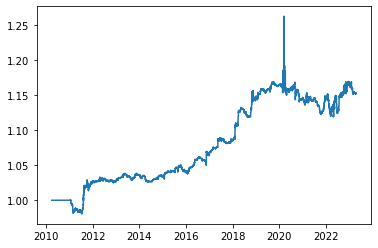

In [125]:
pnl=df*rets.shift(2)
pnl['sum']=pnl.sum(axis=1)
level=(1+pnl['sum']).cumprod()
_=plt.plot(level)

In [37]:
# use the Nelder-Mead method to minimize the function
res_ms = minimize(lambda x: rolling_strategy_sharpe(df_ms,x[0],x[1]),x0, method='SLSQP',
               bounds=bounds, constraints=constraints)

# print the optimized values and the function value
print("MSFT Optimized values:", res_ms.x)
ma1,ma2=[int(val) for val in res_ms.x]
_,tot_return=build_pnl(df_ms,ma1,ma2)
print("Optimized Sharpe:", res_ms.fun)
print("Total return:", tot_return)

MSFT Optimized values: [ 38. 200.]
Optimized Sharpe: 0.66477083340012
5.590971509346413


In [38]:
# use the Nelder-Mead method to minimize the function
res_gog = minimize(lambda x: rolling_strategy_sharpe(df_goo,x[0],x[1]),x0, method='SLSQP',
               bounds=bounds, constraints=constraints)

# print the optimized values and the function value
print("Google Optimized values:", res_gog.x)
ma1,ma2=[int(val) for val in res_gog.x]
_,tot_return=build_pnl(df_goo,ma1,ma2)
print("Optimized Sharpe:", res_gog.fun)
print("Total return:", tot_return)

Google Optimized values: [ 38. 200.]
Optimized Sharpe: 0.24014649585717396
Total return: 1.412668865531073


In [39]:
# use the Nelder-Mead method to minimize the function
res_nv = minimize(lambda x: rolling_strategy_sharpe(df_nv,x[0],x[1]),x0, method='SLSQP',
               bounds=bounds, constraints=constraints)

# print the optimized values and the function value
print("NVDA Optimized values:", res_nv.x)
ma1,ma2=[int(val) for val in res_nv.x]
_,tot_return=build_pnl(df_nv,ma1,ma2)
print("Optimized Sharpe:", res_nv.fun)
print("Total return:", tot_return)

NVDA Optimized values: [ 38. 200.]
Optimized Sharpe: 0.8989429845496721
Total return: 40.339112206977546


In [40]:
# use the Nelder-Mead method to minimize the function
res_ap = minimize(lambda x: rolling_strategy_sharpe(df_ap,x[0],x[1]),x0, method='SLSQP',
               bounds=bounds, constraints=constraints)

# print the optimized values and the function value
print("Apple Optimized values:", res_ap.x)
ma1,ma2=[int(val) for val in res_ap.x]
_,tot_return=build_pnl(df_ap,ma1,ma2)
print("Optimized Sharpe:", res_ap.fun)
print("Total return:", tot_return)

Apple Optimized values: [ 38. 200.]
Optimized Sharpe: 0.6994781176093147
Total return: 7.095811319830842


In [41]:
# use the Nelder-Mead method to minimize the function
res_amz = minimize(lambda x: rolling_strategy_sharpe(df_amz,x[0],x[1]),x0, method='SLSQP',
               bounds=bounds, constraints=constraints)

# print the optimized values and the function value
print("Amazon Optimized values:", res_amz.x)
ma1,ma2=[int(val) for val in res_amz.x]
_,tot_return=build_pnl(df_amz,ma1,ma2)
print("Optimized Sharpe:", res_amz.fun)
print("Total return:", tot_return)

Amazon Optimized values: [ 38. 200.]
Optimized Sharpe: 0.45365661614478503
Total return: 3.2156069087007366


In [42]:
# use the Nelder-Mead method to minimize the function
res_lr = minimize(lambda x: rolling_strategy_sharpe(df_lr,x[0],x[1]),x0, method='SLSQP',
               bounds=bounds, constraints=constraints)

# print the optimized values and the function value
print("LRCX Optimized values:", res_lr.x)
ma1,ma2=[int(val) for val in res_lr.x]
_,tot_return=build_pnl(df_lr,ma1,ma2)
print("Optimized Sharpe:", res_lr.fun)
print("Total return:", tot_return)

LRCX Optimized values: [ 38. 200.]
Optimized Sharpe: 0.461051189009498
Total return: 3.5371892533743674


[*********************100%***********************]  1 of 1 completed
Position changes at  [Timestamp('2011-01-13 00:00:00'), Timestamp('2011-04-14 00:00:00'), Timestamp('2011-08-05 00:00:00'), Timestamp('2011-09-09 00:00:00'), Timestamp('2011-10-13 00:00:00'), Timestamp('2012-10-23 00:00:00'), Timestamp('2013-04-18 00:00:00'), Timestamp('2015-02-26 00:00:00'), Timestamp('2015-05-21 00:00:00'), Timestamp('2015-09-28 00:00:00'), Timestamp('2015-10-16 00:00:00'), Timestamp('2016-06-17 00:00:00'), Timestamp('2016-07-27 00:00:00'), Timestamp('2019-01-30 00:00:00'), Timestamp('2019-02-25 00:00:00'), Timestamp('2022-03-08 00:00:00'), Timestamp('2023-03-07 00:00:00')]
Total return for  MSFT
Long Only    13.009580
Strategy      9.414939
Name: 2023-04-21 00:00:00, dtype: float64
Annualized Vol for  MSFT
Long Only    0.263768
Strategy     0.231524
dtype: float64
Annualized Sharpe for  MSFT
Long Only    0.926232
Strategy     0.906757
dtype: float64
[*********************100%***********************

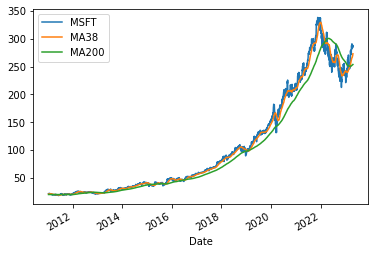

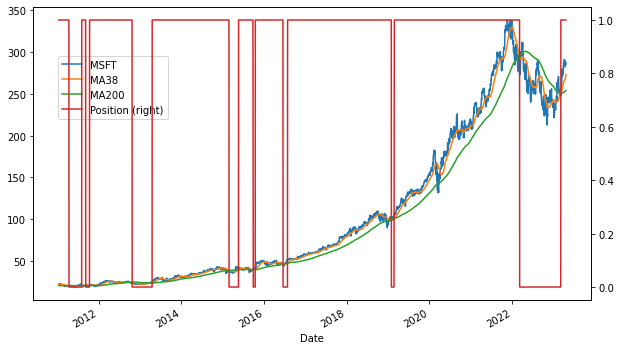

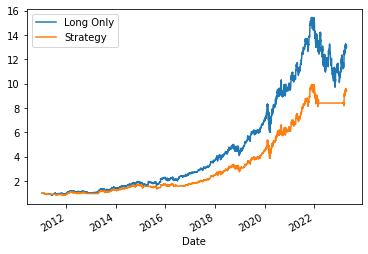

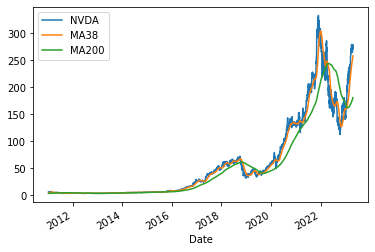

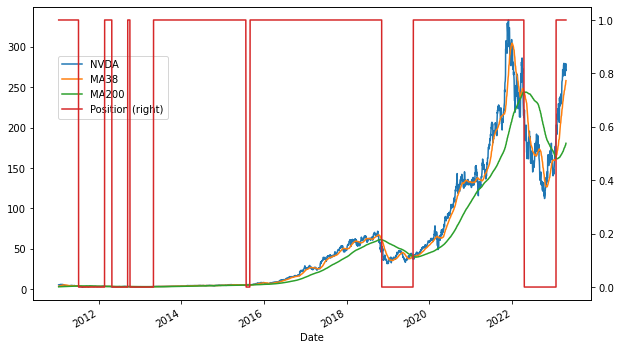

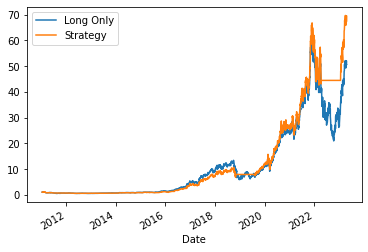

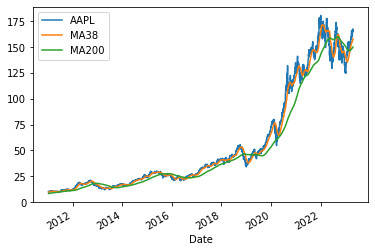

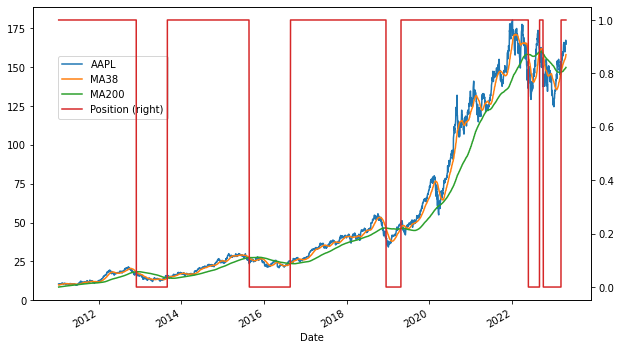

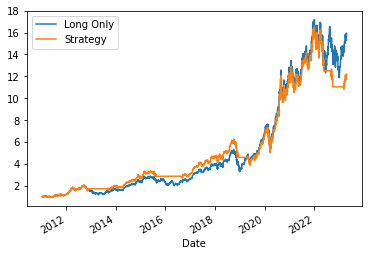

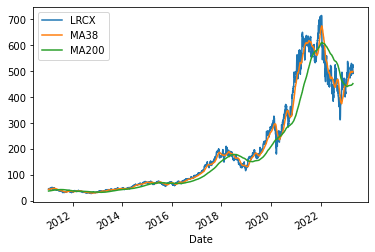

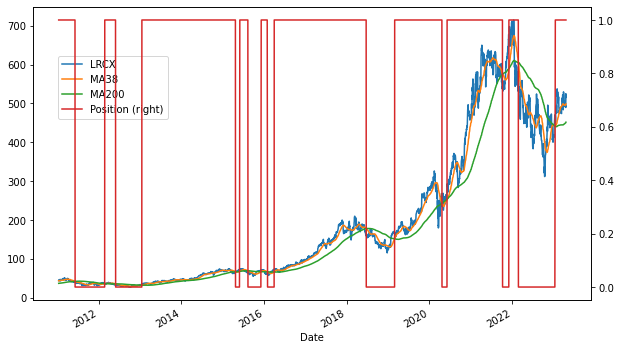

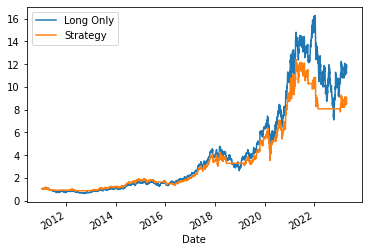

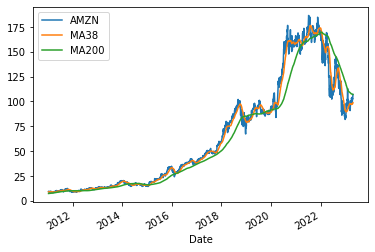

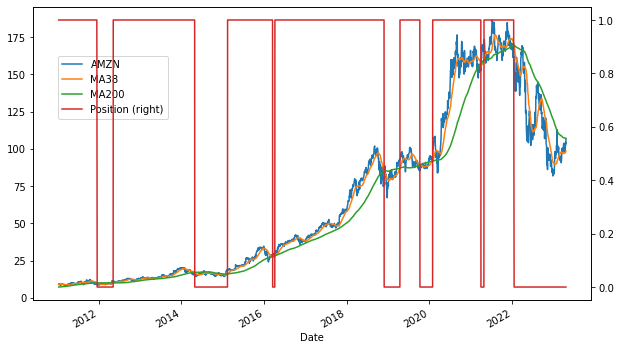

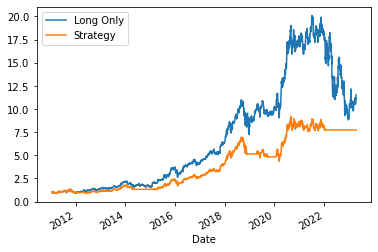

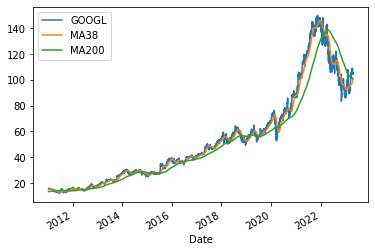

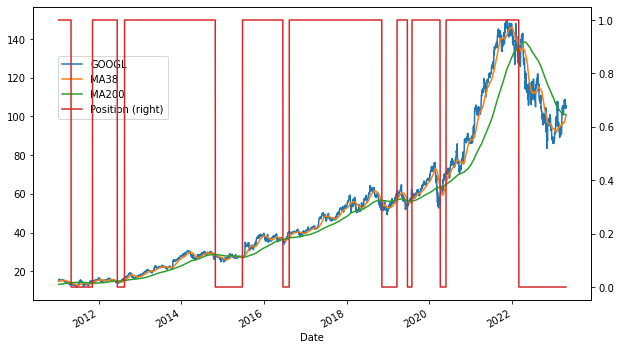

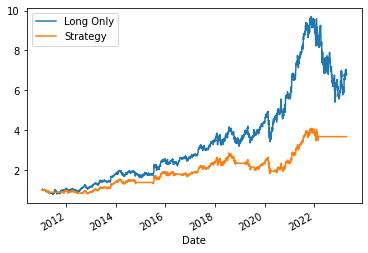

In [58]:
tickers=['MSFT','NVDA','AAPL','LRCX','AMZN','GOOGL']
for tic in tickers:
    rolling_strategy(start_date,end_date,tic,38,200)